<a href="https://colab.research.google.com/github/Mayuresh-12/Dog_Breed_Identification/blob/main/Dog_Breed_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Dog_breed_Data/dog-breed-identification.zip"

In [4]:
import tensorflow as tf
import pandas as pd
from IPython.display import Image
print("TF Version: ", tf.__version__)

TF Version:  2.8.0


In [5]:
import tensorflow_hub as hub 

Step 1: Getting data into Tensors (numerical format).

In [6]:
labels_csv = pd.read_csv("/content/drive/MyDrive/DogVision/dog_breed_identification/labels.csv")

In [7]:
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


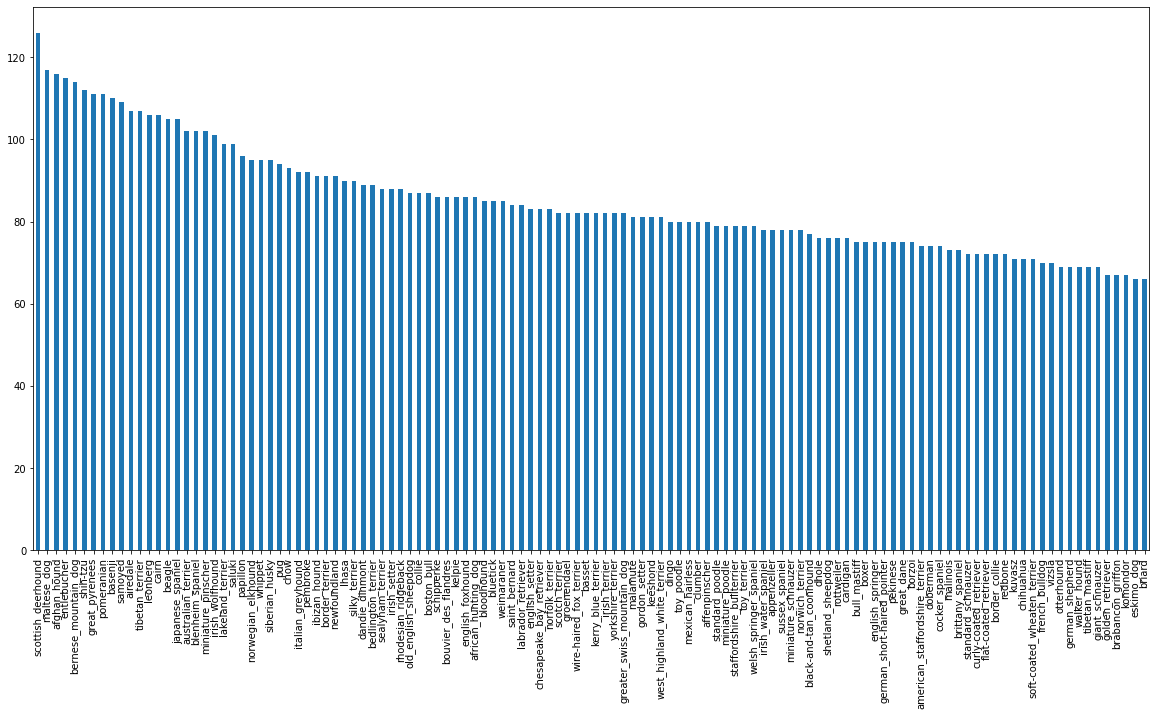

In [8]:
labels_csv["breed"].value_counts().plot.bar(figsize = (20,10))

In [9]:
# Median number of instances per class.

labels_csv["breed"].value_counts().median()

82.0

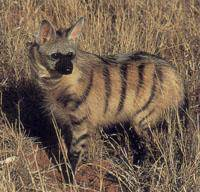

In [10]:
Image("/content/dog-breed-identification/train/00792e341f3c6eb33663e415d0715370.jpg")

### Get all the filenames into a list



In [11]:
filenames = ["/content/dog-breed-identification/train/" + filename + ".jpg" for filename in labels_csv["id"]]

In [12]:
filenames[:5]

['/content/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

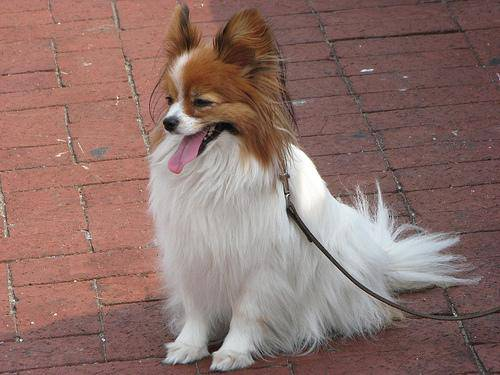

In [13]:
Image(filenames[8176])

In [14]:
labels_csv["breed"][8176]

'papillon'

In [15]:
labels = labels_csv["breed"].to_numpy() 

In [16]:
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [17]:
if len(labels) == len(filenames):
  print("No missing data!")
else:
  print("There's some missing data!")

No missing data!


In [18]:
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [19]:
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:3]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [20]:
# Creating a validation set
X = filenames
y = boolean_labels

## Start off with ~1k images and then step it up as we go.


In [21]:
# Set the number of images for experimentation

NUM_IMAGES = 1000 #@param {type: "slider", min:1000, max:10000, step:1000}

In [22]:
# Split train data into training and validation sets.
from sklearn.model_selection import train_test_split

# Split into training and validation sets of total size NUM_IMAGES.
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size = 0.2,
                                                  random_state = 4)

len(X_train), len(y_train), len(X_val), len(y_val)



(800, 800, 200, 200)

## Preprocessing images

To preprocess our images into Tensors, a function to do the following actions-
1. Takes an image filename as input.
2. Uses TensorFlow to read the file and save it to a variable, `image`.
3. Turn our `image` (a jpeg file) into Tensors.
4. Normalize the image by converting the Tensor from a 0-255 range to a 0-1 value range.
5. Resize the `image` to be of shape (224, 224).
6. Return the modified `image`.

In [23]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[2]) # read in an image
image.shape

(375, 500, 3)

In [24]:
# Convert the above image into a tensor 

tf.constant(image)

<tf.Tensor: shape=(375, 500, 3), dtype=uint8, numpy=
array([[[ 97,  96,  91],
        [102, 101,  96],
        [108, 107, 102],
        ...,
        [ 10,  12,  11],
        [ 10,  12,  11],
        [ 10,  12,  11]],

       [[ 99,  98,  93],
        [102, 101,  96],
        [108, 107, 102],
        ...,
        [ 18,  20,  19],
        [ 18,  20,  19],
        [ 18,  20,  19]],

       [[ 99,  98,  93],
        [ 99,  98,  93],
        [102, 101,  96],
        ...,
        [  8,   8,   8],
        [  8,   8,   8],
        [  8,   8,   8]],

       ...,

       [[193, 192, 188],
        [194, 193, 189],
        [195, 194, 190],
        ...,
        [118, 117, 113],
        [130, 129, 125],
        [128, 127, 123]],

       [[199, 198, 194],
        [200, 199, 195],
        [201, 200, 196],
        ...,
        [116, 115, 110],
        [107, 106, 101],
        [108, 107, 102]],

       [[199, 198, 194],
        [200, 199, 195],
        [202, 201, 197],
        ...,
        [ 96,  96,  8

# Function to preprocess images

In [25]:
# Define Image Size
IMG_SIZE = 224

# Create function to preprocess images
def preprocess_image(image_path):
  '''
  Takes an image file path as input and converts it into a Tensor.
  '''

  image = tf.io.read_file(image_path)

  # Turn the .jpg image into a Tensor with 3 color channels (RGB)
  image = tf.decode_jpeg(image, channels = 3)
  # Convert the color channel values from 0-255 to 0-1 values
  image = tf.convert_image_dtype(image, tf.float32)
  # Resize the image to (224, 224)
  image = tf.resize_image(image, size = [IMG_SIZE, IMG_SIZE])

  return image

### Convert data into batches

Get data in the form of Tensor tuples-
`(image, label)`


In [27]:
# Function to return a tensor tuple (image, label)
def make_image_label_tuple(image_path, label):
  '''
  Takes an image file path and it's label, processes the image and returns a tuple of (image, label).
  '''

  image = preprocess_image(image_path)
  return image,label


